# 利用thchs30为例建立一个语音识别系统


- 数据处理
- 搭建模型
    - DFCNN

论文地址：http://www.infocomm-journal.com/dxkx/CN/article/downloadArticleFile.do?attachType=PDF&id=166970

## 1. 特征提取

input为输入音频数据，需要转化为频谱图数据，然后通过cnn处理图片的能力进行识别。

**1. 读取音频文件**

<class 'numpy.ndarray'>
(157000,)


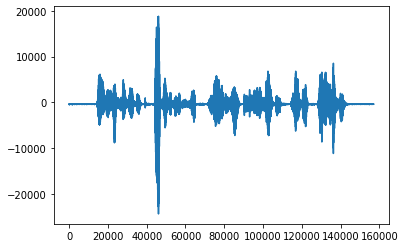

In [11]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os

# 随意搞个音频做实验
filepath = 'test.wav'

fs, wavsignal = wav.read(filepath)
print(type(wavsignal))
print(wavsignal.shape)
plt.plot(wavsignal)
plt.show()

**2. 构造汉明窗**

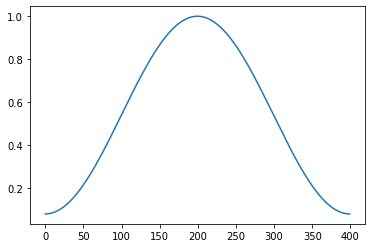

In [12]:
import numpy as np

x=np.linspace(0, 400 - 1, 400, dtype = np.int64)#返回区间内的均匀数字
# print(x)
w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))
plt.plot(w)
plt.show()

**3. 对数据分帧**

- 帧长： 25ms
- 帧移： 10ms


```
采样点（s） = fs
采样点（ms）= fs / 1000
采样点（帧）= fs / 1000 * 帧长
```

In [8]:
time_window = 25
window_length = fs // 1000 * time_window
#保持window

**4. 分帧加窗**

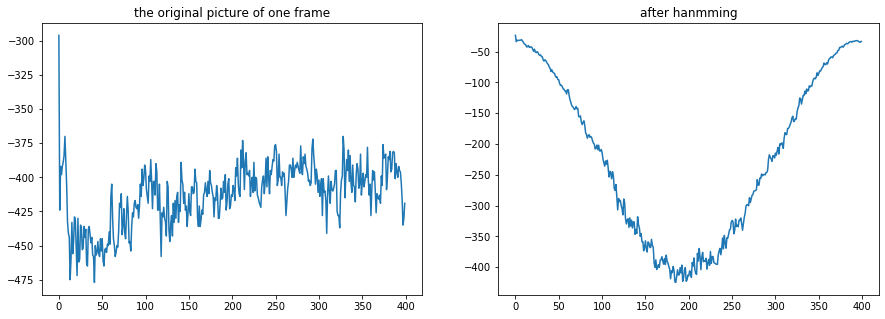

In [26]:
# 分帧
p_begin = 0
p_end = p_begin + window_length
frame = wavsignal[p_begin:p_end]

plt.figure(figsize=(15, 5))
ax4 = plt.subplot(121)
ax4.set_title('the original picture of one frame')
ax4.plot(frame)

# plt.show()
# 加窗

frame = frame * w
ax5 = plt.subplot(122)
ax5.set_title('after hanmming')
ax5.plot(frame)
plt.show()

**5. 傅里叶变换**

所谓时频图就是将时域信息转换到频域上去，具体原理可百度。人耳感知声音是通过

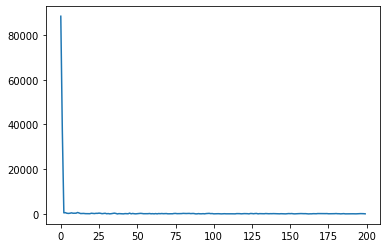

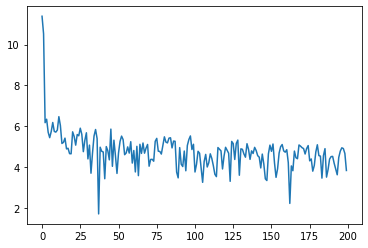

In [10]:
from scipy.fftpack import fft

# 进行快速傅里叶变换
frame_fft = np.abs(fft(frame))[:200]
plt.plot(frame_fft)
plt.show()

# 取对数，求db
frame_log = np.log(frame_fft)
plt.plot(frame_log)
plt.show()


- 分帧
- 加窗
- 傅里叶变换

In [2]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import fft


# 获取信号的时频图
def compute_fbank(file):
	x=np.linspace(0, 400 - 1, 400, dtype = np.int64)
	w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1) ) # 汉明窗
	fs, wavsignal = wav.read(file)
	# wav波形 加时间窗以及时移10ms
	time_window = 25 # 单位ms
	window_length = fs / 1000 * time_window # 计算窗长度的公式，目前全部为400固定值
	wav_arr = np.array(wavsignal)
	wav_length = len(wavsignal)
	range0_end = int(len(wavsignal)/fs*1000 - time_window) // 10 # 计算循环终止的位置，也就是最终生成的窗数
# 	print(range0_end)
	data_input = np.zeros((range0_end, 200), dtype = np.float) # 用于存放最终的频率特征数据
	data_line = np.zeros((1, 400), dtype = np.float)#窗口内的数据
	for i in range(0, range0_end):
		p_start = i * 160#步长10ms所以
		p_end = p_start + 400#窗口长25ms
		data_line = wav_arr[p_start:p_end]	
		data_line = data_line * w # 加窗
		data_line = np.abs(fft(data_line))
		data_input[i]=data_line[0:200] # 设置为400除以2的值（即200）是取一半数据，因为是对称的
	data_input = np.log(data_input + 1)
	#data_input = data_input[::]
	return data_input


- 该函数提取音频文件的时频图

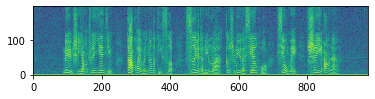

In [3]:
import matplotlib.pyplot as plt
filepath = 'test.wav'

a = compute_fbank(filepath)
# print(a.shape)
plt.imshow(a.T, origin = 'lower')
plt.show()

In [4]:
a.shape

(978, 200)

## 2. 数据处理

#### 下载数据
thchs30: http://www.openslr.org/18/

### 2.1 生成音频文件和标签文件列表
考虑神经网络训练过程中接收的输入输出。首先需要batch_size内数据需要统一数据的shape。

**格式为**：[batch_size, time_step, feature_dim]

然而读取的每一个sample的时间轴长都不一样，所以需要对时间轴进行处理，选择batch内最长的那个时间为基准，进行padding。这样一个batch内的数据都相同，就能进行并行训练啦。


In [3]:
source_file = 'data_thchs30'

#### 定义函数`source_get`，获取音频文件及标注文件列表

形如：
```
E:\Data\thchs30\data_thchs30\data\A11_0.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_1.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_10.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_100.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_102.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_103.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_104.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_105.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_106.wav.trn
E:\Data\thchs30\data_thchs30\data\A11_107.wav.trn
```

In [6]:
def source_get(source_file):
    train_file = source_file + '/data'
    label_lst = []
    wav_lst = []
    for root, dirs, files in os.walk(train_file):
        for file in files:
            if file.endswith('.wav') or file.endswith('.WAV'):
                wav_file = os.sep.join([root, file])
                label_file = wav_file + '.trn'
                wav_lst.append(wav_file)
                label_lst.append(label_file)
            
    return label_lst, wav_lst

label_lst, wav_lst = source_get(source_file)

print(label_lst[:10])
print(wav_lst[:10])

['data_thchs30/data/D11_982.wav.trn', 'data_thchs30/data/D12_841.wav.trn', 'data_thchs30/data/B8_298.wav.trn', 'data_thchs30/data/D6_889.wav.trn', 'data_thchs30/data/C32_692.wav.trn', 'data_thchs30/data/A14_44.wav.trn', 'data_thchs30/data/B31_478.wav.trn', 'data_thchs30/data/A11_184.wav.trn', 'data_thchs30/data/A8_220.wav.trn', 'data_thchs30/data/B12_271.wav.trn']
['data_thchs30/data/D11_982.wav', 'data_thchs30/data/D12_841.wav', 'data_thchs30/data/B8_298.wav', 'data_thchs30/data/D6_889.wav', 'data_thchs30/data/C32_692.wav', 'data_thchs30/data/A14_44.wav', 'data_thchs30/data/B31_478.wav', 'data_thchs30/data/A11_184.wav', 'data_thchs30/data/A8_220.wav', 'data_thchs30/data/B12_271.wav']


#### 确认相同id对应的音频文件和标签文件相同

In [7]:
for i in range(10000):
    wavname = (wav_lst[i].split('/')[-1]).split('.')[0]
    labelname = (label_lst[i].split('/')[-1]).split('.')[0]
    if wavname != labelname:
        print('error')

### 2.2 label数据处理
#### 定义函数`read_label`读取音频文件对应的拼音label

In [8]:
def read_label(label_file):
    with open(label_file, 'r', encoding='utf8') as f:
        data = f.readlines()
        return data[1]

print(read_label(label_lst[0]))

def gen_label_data(label_lst):
    label_data = []
    for label_file in label_lst:
        pny = read_label(label_file)
        label_data.append(pny.strip('\n'))
    return label_data

label_data = gen_label_data(label_lst)
print(len(label_data))

ru2 guo3 xia4 dao4 gu2 di3 dun4 jue2 han2 qi4 xi2 ren2 tai2 tou2 si4 gu4 yin1 sen1 sen1 de5 tu3 bi4 que4 you3 qun2 mo2 ya1 ding3 de5 jing1 xin1 dong4 po4 zhi1 gan3

13388


#### 为label建立拼音到id的映射，即词典

In [9]:
def mk_vocab(label_data):
    vocab = []
    for line in label_data:
        line = line.split(' ')
        for pny in line:
            if pny not in vocab:
                vocab.append(pny)
    vocab.append('_')
    return vocab

vocab = mk_vocab(label_data)
# print(len(vocab))

#### 有了词典就能将读取到的label映射到对应的id

In [10]:
def word2id(line, vocab):
    return [vocab.index(pny) for pny in line.split(' ')]

label_id = word2id(label_data[0], vocab)
print(label_data[0])
print(label_id)

ru2 guo3 xia4 dao4 gu2 di3 dun4 jue2 han2 qi4 xi2 ren2 tai2 tou2 si4 gu4 yin1 sen1 sen1 de5 tu3 bi4 que4 you3 qun2 mo2 ya1 ding3 de5 jing1 xin1 dong4 po4 zhi1 gan3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 18, 27, 28, 29, 30, 31, 32]


#### 总结:
我们提取出了每个音频文件对应的拼音标签`label_data`，通过索引就可以获得该索引的标签。

也生成了对应的拼音词典.由此词典，我们可以映射拼音标签为id序列。

输出：
- vocab
- label_data

In [11]:
print(vocab[:15])
print(label_data[10])
print(word2id(label_data[10], vocab))

['ru2', 'guo3', 'xia4', 'dao4', 'gu2', 'di3', 'dun4', 'jue2', 'han2', 'qi4', 'xi2', 'ren2', 'tai2', 'tou2', 'si4']
lao2 qu3 tou2 hua4 yu3 hen3 shi2 cheng5 you4 si4 hu1 yan2 you2 mo4 jin4 ta1 yi4 ku3 shi2 tan2 de5 chang4 kuai4 si1 tian2 shi2 que4 tun1 tun1 tu2 tu3 xian3 ran2 you3 nan2 yan2 zhi1 yin3
[211, 212, 13, 213, 214, 189, 75, 215, 118, 14, 216, 217, 186, 218, 219, 137, 53, 220, 75, 221, 18, 222, 223, 87, 224, 75, 21, 225, 225, 226, 19, 227, 228, 22, 159, 217, 31, 229]


### 2.3 音频数据处理

音频数据处理，只需要获得对应的音频文件名，然后提取所需时频图即可。

其中`compute_fbank`时频转化的函数在前面已经定义好了。

In [12]:
fbank = compute_fbank(wav_lst[0])
print(wav_lst[0])
print(fbank.shape)

data_thchs30/data/D11_982.wav
(1041, 200)


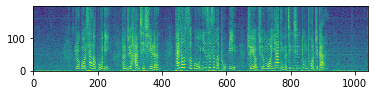

In [13]:
plt.imshow(fbank.T, origin = 'lower')
plt.show()

#### 由于声学模型网络结构原因（3个maxpooling层），我们的音频数据的每个维度需要能够被8整除。

In [14]:
fbank = fbank[:fbank.shape[0]//8*8, :]

In [15]:
print(fbank.shape)

(1040, 200)


#### 总结：
- 对音频数据进行时频转换
- 转换后的数据需要各个维度能够被8整除

### 2.4 数据生成器
#### 确定batch_size和batch_num

In [16]:
total_nums = 10000
batch_size = 4
batch_num = total_nums // batch_size

#### shuffle
打乱数据的顺序，我们通过查询乱序的索引值，来确定训练数据的顺序

In [17]:
from random import shuffle
shuffle_list = [i for i in range(10000)]
shuffle(shuffle_list)

#### generator
batch_size的信号时频图和标签数据，存放到两个list中去

In [18]:
def get_batch(batch_size, shuffle_list, wav_lst, label_data, vocab):
    for i in range(10000//batch_size):
        wav_data_lst = []
        label_data_lst = []
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        for index in sub_list:
            fbank = compute_fbank(wav_lst[index])
            fbank = fbank[:fbank.shape[0] // 8 * 8, :]
            label = word2id(label_data[index], vocab)
            wav_data_lst.append(fbank)
            label_data_lst.append(label)
        yield wav_data_lst, label_data_lst

batch = get_batch(4, shuffle_list, wav_lst, label_data, vocab)


In [19]:
wav_data_lst, label_data_lst = next(batch)
for wav_data in wav_data_lst:
    print(wav_data.shape)
for label_data in label_data_lst:
    print(label_data)

(912, 200)
(784, 200)
(800, 200)
(896, 200)
[221, 274, 824, 158, 837, 48, 264, 962, 1172, 48, 264, 274, 408, 146, 351, 76, 301, 1147, 274, 125, 339, 31, 297, 324, 22, 336, 491, 624, 753, 18, 234, 408]
[648, 625, 54, 560, 346, 977, 374, 280, 108, 430, 405, 281, 84, 186, 90, 37, 250, 53, 445, 53, 286, 37, 250, 208, 271, 290, 86, 346, 19, 353, 97, 282]
[977, 290, 146, 267, 20, 507, 502, 109, 137, 180, 16, 174, 137, 180, 20, 489, 246, 346, 174, 800, 66, 243, 104, 721, 7, 755, 254, 209, 94, 97, 499, 1049, 66, 443, 505, 230]
[41, 720, 496, 203, 618, 96, 324, 576, 687, 342, 41, 22, 430, 28, 324, 203, 41, 22, 417, 28, 496, 203, 41, 22, 704, 28]


In [20]:
lens = [len(wav) for wav in wav_data_lst]
print(max(lens))
print(lens)

912
[912, 784, 800, 896]


#### padding
然而，每一个batch_size内的数据有一个要求，就是需要构成成一个tensorflow块，这就要求每个样本数据形式是一样的。
除此之外，ctc需要获得的信息还有输入序列的长度。
这里输入序列经过卷积网络后，长度缩短了8倍，因此我们训练实际输入的数据为wav_len//8。
- padding wav data
- wav len // 8 （网络结构导致的）

In [21]:
def wav_padding(wav_data_lst):
    wav_lens = [len(data) for data in wav_data_lst]
    wav_max_len = max(wav_lens)
    wav_lens = np.array([leng//8 for leng in wav_lens])
    new_wav_data_lst = np.zeros((len(wav_data_lst), wav_max_len, 200, 1))
    for i in range(len(wav_data_lst)):
        new_wav_data_lst[i, :wav_data_lst[i].shape[0], :, 0] = wav_data_lst[i]
    return new_wav_data_lst, wav_lens

pad_wav_data_lst, wav_lens = wav_padding(wav_data_lst)
print(pad_wav_data_lst.shape)
print(wav_lens)

(4, 912, 200, 1)
[114  98 100 112]


同样也要对label进行padding和长度获取，不同的是数据维度不同，且label的长度就是输入给ctc的长度，不需要额外处理
- label padding
- label len

In [22]:
def label_padding(label_data_lst):
    label_lens = np.array([len(label) for label in label_data_lst])
    max_label_len = max(label_lens)
    new_label_data_lst = np.zeros((len(label_data_lst), max_label_len))
    for i in range(len(label_data_lst)):
        new_label_data_lst[i][:len(label_data_lst[i])] = label_data_lst[i]
    return new_label_data_lst, label_lens

pad_label_data_lst, label_lens = label_padding(label_data_lst)
print(pad_label_data_lst.shape)
print(label_lens)

(4, 36)
[32 32 36 26]


- 用于训练格式的数据生成器

In [36]:
def data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab):
    for i in range(len(wav_lst)//batch_size):
        wav_data_lst = []
        label_data_lst = []
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        for index in sub_list:
            fbank = compute_fbank(wav_lst[index])
#             print(wav_lst[index])
            pad_fbank = np.zeros((fbank.shape[0]//8*8+8, fbank.shape[1]))
            pad_fbank[:fbank.shape[0], :] = fbank
            label = word2id(label_data[index], vocab)
            wav_data_lst.append(pad_fbank)
            label_data_lst.append(label)
#             break
        pad_wav_data, input_length = wav_padding(wav_data_lst)
        pad_label_data, label_length = label_padding(label_data_lst)
        inputs = {'the_inputs': pad_wav_data,
                  'the_labels': pad_label_data,
                  'input_length': input_length,
                  'label_length': label_length,
                 }
#         print(pad_wav_data,pad_label_data,input_length,label_length)
        outputs = {'ctc': np.zeros(pad_wav_data.shape[0],)} 
        yield inputs, outputs

## 3. 模型搭建

训练输入为时频图，标签为对应的拼音标签，如下所示：


搭建语音识别模型，采用了 CNN+CTC 的结构。
![dfcnn.jpg](attachment:dfcnn.jpg)

In [24]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Reshape, Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.utils import multi_gpu_model
from keras.models import load_model

Using TensorFlow backend.


- 定义3*3的卷积层

In [25]:
def conv2d(size):
    return Conv2D(size, (3,3), use_bias=True, activation='relu',
        padding='same', kernel_initializer='he_normal')

- 定义batch norm层

In [26]:
def norm(x):
    return BatchNormalization(axis=-1)(x)

- 定义最大池化层，数据的后两维维度都减半

In [27]:
def maxpool(x):
    return MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(x)

- dense层

In [28]:
def dense(units, activation="relu"):
    return Dense(units, activation=activation, use_bias=True,
        kernel_initializer='he_normal')

- 由cnn + cnn + maxpool构成的组合

In [29]:
# x.shape=(none, none, none)
# output.shape = (1/2, 1/2, 1/2)
def cnn_cell(size, x, pool=True):
    x = norm(conv2d(size)(x))
    x = norm(conv2d(size)(x))
    if pool:
        x = maxpool(x)
    return x

- **添加CTC损失函数，由backend引入**

**注意：CTC_batch_cost输入为：**

- **labels** 标签：[batch_size, l]
- **y_pred** cnn网络的输出：[batch_size, t, vocab_size]
- **input_length** 网络输出的长度：[batch_size]
- **label_length** 标签的长度：[batch_size]

In [30]:
def ctc_lambda(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### **搭建cnn+dnn+ctc的声学模型**

In [31]:
class Amodel():
    """docstring for Amodel."""
    def __init__(self, vocab_size):
        super(Amodel, self).__init__()
        self.vocab_size = vocab_size
        self._model_init()
        self._ctc_init()
        self.opt_init()

    def _model_init(self):
        self.inputs = Input(name='the_inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        # 200 / 8 * 128 = 3200
        self.h6 = Reshape((-1, 3200))(self.h4)
        self.h7 = dense(256)(self.h6)
        self.outputs = dense(self.vocab_size, activation='softmax')(self.h7)
        self.model = Model(inputs=self.inputs, outputs=self.outputs)

    def _ctc_init(self):
        self.labels = Input(name='the_labels', shape=[None], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        self.loss_out = Lambda(ctc_lambda, output_shape=(1,), name='ctc')\
            ([self.labels, self.outputs, self.input_length, self.label_length])
        self.ctc_model = Model(inputs=[self.labels, self.inputs,
            self.input_length, self.label_length], outputs=self.loss_out)

    def opt_init(self):
        opt = Adam(lr = 0.0008, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01, epsilon = 10e-8)
        #self.ctc_model=multi_gpu_model(self.ctc_model,gpus=2)
        self.ctc_model.compile(loss={'ctc': lambda y_true, output: output}, optimizer=opt)
#     def load_model(self,file):
#         self.ctc_model.load_model(file)


In [32]:
am = Amodel(1176)
am.ctc_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 200, 32 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, N

## 4. 开始训练

这样训练所需的数据，就准备完毕了，接下来可以进行训练了。我们采用如下参数训练：
- batch_size = 4
- batch_num = 10000 // 4
- epochs = 1

- **准备训练数据，shuffle是为了打乱训练数据顺序**

In [33]:
total_nums = 100
batch_size = 20
batch_num = total_nums // batch_size
epochs = 50

In [34]:
source_file = 'data_thchs30'
label_lst, wav_lst = source_get(source_file)
label_data = gen_label_data(label_lst[:100])
vocab = mk_vocab(label_data)
vocab_size = len(vocab)

# print(vocab_size)

shuffle_list = [i for i in range(100)]


- 使用fit_generator

- 开始训练

In [37]:
am = Amodel(vocab_size)

for k in range(epochs):
    print('this is the', k+1, 'th epochs trainning !!!')
    #shuffle(shuffle_list)
    batch = data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab)
    am.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)
am.ctc_model.save_weights('res2.h5')

this is the 1 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 117s 23s/step - loss: 347.9154
this is the 2 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 104s 21s/step - loss: 235.1735
this is the 3 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 103s 21s/step - loss: 225.2550
this is the 4 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 103s 21s/step - loss: 216.4999
this is the 5 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 102s 20s/step - loss: 206.7374
this is the 6 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 102s 20s/step - loss: 200.8864
this is the 7 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 103s 21s/step - loss: 195.0210
this is the 8 th epochs trainning !!!
Epoch 1/1
5/5 [==============================] - 102s 20s/step - loss: 188.3000
this is the 9 th epochs trainning !!!
Epoch 1/1
5/5 [===

In [ ]:
import json
with open('model_def.json','w') as ff:
    json_string = am.model.to_json()
    ff.write(json_string)#保存模型信息
    
sep = '\n'
fl=open('pinyin_list.txt', 'w')
fl.write(sep.join(py))
fl.close()#保存拼音列表